## Libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold

## Data load & Inspection

In [3]:
data = pd.read_csv('C:/Temp/Titanic/train.csv')

In [4]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [5]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## EDA

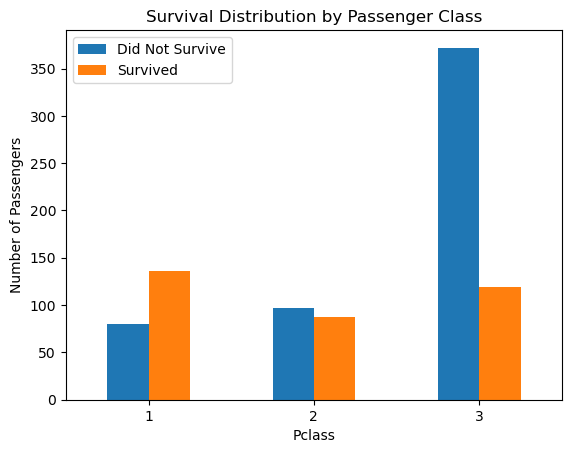

In [7]:
ct_pclass = pd.crosstab(data['Pclass'], data['Survived'])
ct_pclass.plot(kind='bar')

plt.title('Survival Distribution by Passenger Class')
plt.xlabel('Pclass')
plt.ylabel('Number of Passengers')
plt.legend(['Did Not Survive', 'Survived'])
plt.xticks(rotation=0)
plt.show()

Social economic status level 3 shows a clear high correlation with non-survivers

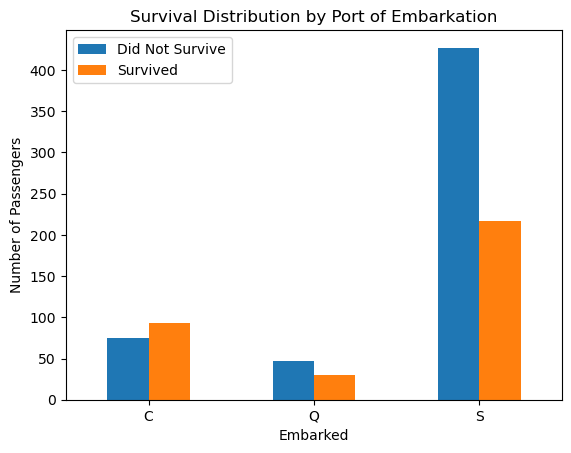

In [8]:
ct_embarked = pd.crosstab(data['Embarked'], data['Survived'])
ct_embarked.plot(kind='bar')

plt.title('Survival Distribution by Port of Embarkation')
plt.xlabel('Embarked')
plt.ylabel('Number of Passengers')
plt.legend(['Did Not Survive', 'Survived'])
plt.xticks(rotation=0)
plt.show()

Passengers coming from the Southhampton port shows high correlation with non-survivers, however this is not a strong signal for the model.

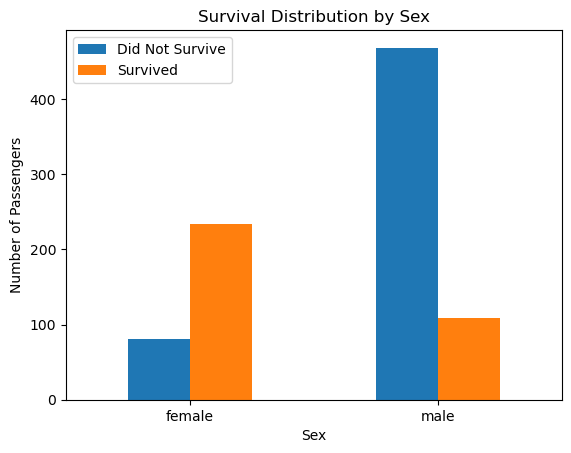

In [9]:
ct_sex = pd.crosstab(data['Sex'], data['Survived'])
ct_sex.plot(kind='bar')

plt.title('Survival Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Number of Passengers')
plt.legend(['Did Not Survive', 'Survived'])
plt.xticks(rotation=0)
plt.show()

"Women & children first"

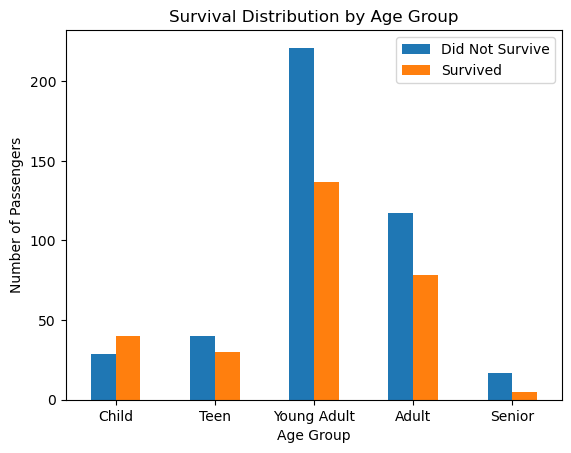

In [10]:
age_bins = [0, 12, 18, 35, 60, 100]
age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']

data['AgeGroup'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels)

ct_age = pd.crosstab(data['AgeGroup'], data['Survived'])
ct_age.plot(kind='bar')

plt.title('Survival Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Passengers')
plt.legend(['Did Not Survive', 'Survived'])
plt.xticks(rotation=0)
plt.show()

Young Adults & Adults have high correlation with Non-survivors.

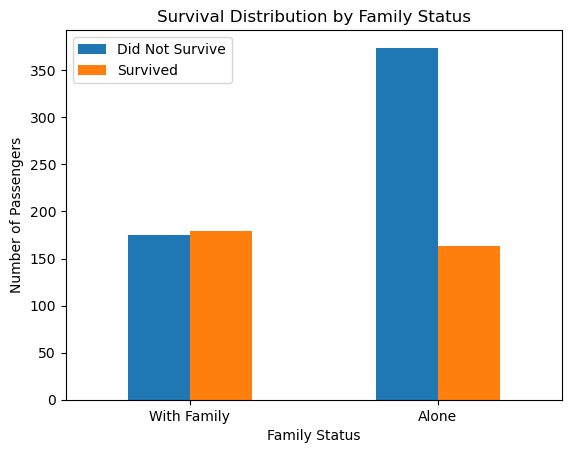

In [11]:
data['FamilySize'] = data['SibSp'] + data['Parch']
data['IsAlone'] = (data['FamilySize'] == 0).astype(int)

ct_family = pd.crosstab(data['IsAlone'], data['Survived'])
ct_family.index = ['With Family', 'Alone']

ct_family.plot(kind='bar')

plt.title('Survival Distribution by Family Status')
plt.xlabel('Family Status')
plt.ylabel('Number of Passengers')
plt.legend(['Did Not Survive', 'Survived'])
plt.xticks(rotation=0)
plt.show()

Travelling alone is another variable to take into considreaction that can give us strong signals of high correlation with non-survivors.

C:\Users\teopr\AppData\Local\Temp\ipykernel_31164\3415635053.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap='seismic')


<Axes: >

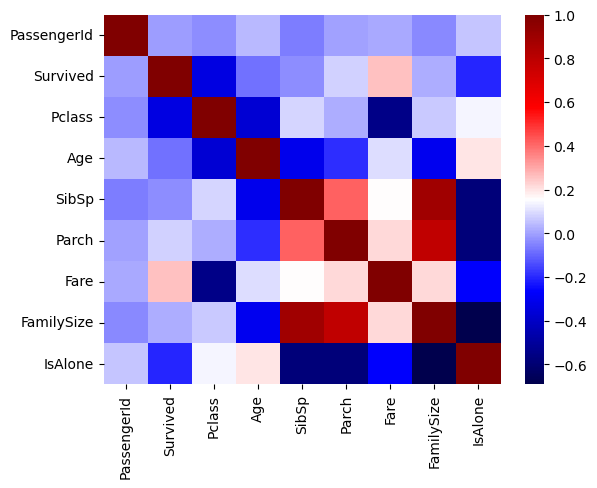

In [12]:
sns.heatmap(data.corr(), cmap='seismic')

## Feature Engineering - Data cleaning

In [13]:
class TitanicPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.age_imputer = SimpleImputer(strategy='median')
        self.fare_imputer = SimpleImputer(strategy='median')
        self.embarked_imputer = SimpleImputer(strategy='constant', fill_value='N')
        self.fare_median = None
    
    def fit(self, X, y=None):
        self.age_imputer.fit(X[['Age']])
        self.fare_imputer.fit(X[['Fare']])
        self.embarked_imputer.fit(X[['Embarked']])
        self.fare_median = X['Fare'].median()
        return self

    def transform(self, X, y=None):
        df = X.copy()

        df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.mean()))
        df['Fare'] = df['Fare'].fillna(self.fare_median)
        df['Embarked'] = self.embarked_imputer.transform(df[['Embarked']]) #Fill missing values

        df['Deck'] = df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'U')
        df.drop('Cabin', axis=1, inplace=True) #Feature engineering

        df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
        df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],
            'Rare')
        df['Title'] = df['Title'].replace({'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs'})
        df.drop('Name', axis=1, inplace=True) #Feature engineering

        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
        df['IsAlone'] = (df['FamilySize'] == 1).astype(int) #Feature engineering

        df['AgeBin'] = pd.cut(df['Age'], bins=[0,12,19,60,120], labels=['Child','Teen','Adult','Senior'])
        df['LogFare'] = np.log1p(df['Fare'])
        df['FareBin'] = pd.qcut(df['Fare'], 4, labels=['Low','Medium','High','VeryHigh']) #Feature engineering

        if 'PassengerId' in df.columns:
            df.drop(['PassengerId', 'Ticket'], axis=1, inplace=True) #Drop unused columns

        return df

In [14]:
numeric_features = ['LogFare', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Deck', 'Title', 'IsAlone', 'AgeBin', 'FareBin']

In [15]:
features = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']

X = data[features]
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
X_train

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
692,3,"Lam, Mr. Ali",male,NaN,0,0,56.4958,NaN,S
481,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,0.0000,NaN,S
527,1,"Farthing, Mr. John",male,NaN,0,0,221.7792,C95,S
855,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,9.3500,NaN,S
801,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,26.2500,NaN,S
...,...,...,...,...,...,...,...,...,...
359,3,"Mockler, Miss. Helen Mary ""Ellie""",female,NaN,0,0,7.8792,NaN,Q
258,1,"Ward, Miss. Anna",female,35.0,0,0,512.3292,NaN,C
736,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,34.3750,NaN,S
462,1,"Gee, Mr. Arthur H",male,47.0,0,0,38.5000,E63,S


In [17]:
X_test

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
565,3,"Davies, Mr. Alfred J",male,24.0,2,0,24.1500,NaN,S
160,3,"Cribb, Mr. John Hatfield",male,44.0,0,1,16.1000,NaN,S
553,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,7.2250,NaN,C
860,3,"Hansen, Mr. Claus Peter",male,41.0,2,0,14.1083,NaN,S
241,3,"Murphy, Miss. Katherine ""Kate""",female,NaN,1,0,15.5000,NaN,Q
...,...,...,...,...,...,...,...,...,...
880,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,26.0000,NaN,S
91,3,"Andreasson, Mr. Paul Edvin",male,20.0,0,0,7.8542,NaN,S
883,2,"Banfield, Mr. Frederick James",male,28.0,0,0,10.5000,NaN,S
473,2,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0,0,13.7917,D,C


In [18]:
y_train

692    1
481    0
527    0
855    1
801    1
      ..
359    1
258    1
736    0
462    0
507    1
Name: Survived, Length: 712, dtype: int64

In [19]:
y_test

565    0
160    0
553    1
860    0
241    1
      ..
880    1
91     0
883    0
473    1
637    0
Name: Survived, Length: 179, dtype: int64

## Pipeline

In [20]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='N')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

full_pipeline = Pipeline(steps=[
    ('feature_engineering', TitanicPreprocessor()),
    ('preprocessor', preprocessor)
])

In [21]:
full_pipeline.fit(X_train)

X_train_transformed = full_pipeline.transform(X_train)

X_test_transformed = full_pipeline.transform(X_test)

In [22]:
type(X_train_transformed)
X_train_transformed.shape

(712, 35)

In [ ]:
preprocessor = full_pipeline.named_steps['preprocessor']

num_features = numeric_features

cat_features = preprocessor.named_transformers_['cat'] \
    .named_steps['onehot'] \
    .get_feature_names_out(categorical_features)

all_features = list(num_features) + list(cat_features)

X_train_df = pd.DataFrame(
    X_train_transformed.toarray() if hasattr(X_train_transformed, "toarray") else X_train_transformed,
    columns=all_features,
    index=X_train.index
)

X_train_df.head() # Dataframe after FE

,LogFare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_N,Embarked_Q,...,IsAlone_0,IsAlone_1,AgeBin_Adult,AgeBin_Child,AgeBin_Senior,AgeBin_Teen,FareBin_High,FareBin_Low,FareBin_Medium,FareBin_VeryHigh
692,1.124592,-0.556339,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
481,-3.014278,-0.556339,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
527,2.508198,-0.556339,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
855,-0.627019,0.073412,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
801,0.361872,0.703162,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [24]:
X_train_df.isna().sum().sum()

0

In [25]:
X_train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
LogFare,712.0,2.432511e-16,1.000703,-3.014278,-0.781684,-0.217501,0.526011,3.360891
FamilySize,712.0,3.492836e-17,1.000703,-0.556339,-0.556339,-0.556339,0.073412,5.741166
Pclass_1,712.0,2.401685e-01,0.427486,0.000000,0.000000,0.000000,0.000000,1.000000
Pclass_2,712.0,2.106742e-01,0.408074,0.000000,0.000000,0.000000,0.000000,1.000000
Pclass_3,712.0,5.491573e-01,0.497927,0.000000,0.000000,1.000000,1.000000,1.000000
Sex_female,712.0,3.553371e-01,0.478952,0.000000,0.000000,0.000000,1.000000,1.000000
Sex_male,712.0,6.446629e-01,0.478952,0.000000,0.000000,1.000000,1.000000,1.000000
Embarked_C,712.0,1.952247e-01,0.396652,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_N,712.0,2.808989e-03,0.052963,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_Q,712.0,7.724719e-02,0.267171,0.000000,0.000000,0.000000,0.000000,1.000000


## Model

In [26]:
lr_model = Pipeline(steps=[
    ('full_preprocessing', full_pipeline),
    ('classifier', LogisticRegression(max_iter=1000))
])

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

y_proba = lr_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)

print("----------------------------------------------------------")
print("Logistic Regression")
print("----------------------------------------------------------")
print(classification_report(y_test, y_pred))
print("----------------------------------------------------------")
print(f"Accuracy: {accuracy:.4f}")
print("----------------------------------------------------------")

----------------------------------------------------------
Logistic Regression
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       110
           1       0.78      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

----------------------------------------------------------
Accuracy: 0.8212
----------------------------------------------------------


In [27]:
rf_model = Pipeline(steps=[
    ('full_preprocessing', full_pipeline),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

y_proba = rf_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)

print("----------------------------------------------------------")
print("Random Forest")
print("----------------------------------------------------------")
print(classification_report(y_test, y_pred))
print("----------------------------------------------------------")
print(f"Accuracy: {accuracy:.4f}")
print("----------------------------------------------------------")

----------------------------------------------------------
Random Forest
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       110
           1       0.73      0.67      0.70        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.78      0.77       179

----------------------------------------------------------
Accuracy: 0.7765
----------------------------------------------------------


In [28]:
xgb_model = Pipeline(steps=[
    ('full_preprocessing', full_pipeline),
    ('classifier', XGBClassifier(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

y_proba = xgb_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)

print("----------------------------------------------------------")
print("XGB Boost")
print("----------------------------------------------------------")
print(classification_report(y_test, y_pred))
print("----------------------------------------------------------")
print(f"Accuracy: {accuracy:.4f}")
print("----------------------------------------------------------")

----------------------------------------------------------
XGB Boost
----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       110
           1       0.76      0.68      0.72        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179

----------------------------------------------------------
Accuracy: 0.7933
----------------------------------------------------------


Under this results I will ruin my predictions with the Logistic Regression model that got the highest accuracy rate in the training stage

## Final Test

In [29]:
test_data = pd.read_csv('C:/Temp/Titanic/test.csv')

In [30]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [ ]:
test_features = test_data[features] 

test_predictions = lr_model.predict(test_features)

######### File ###########
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions
})
submission.to_csv('titanic_submission.csv', index=False)